# Preamble

In [72]:

import argparse
from dataclasses import dataclass
from typing import Any, Literal, Sequence, TypeVar, cast
from math import log

from numpy import array, diff, mean
from numpy.random import Generator, SeedSequence, default_rng

from generate import (
    random_alternatives,
    random_comparisons,
    random_rmp,
    random_srmp,
    balanced_rmp,
    balanced_srmp
)
from mcda_local.core.performance_table import PerformanceTable
from mcda_local.core.ranker import Ranker
from mcda_local.core.relations import PreferenceStructure
from mcda_local.learner.neighbor import Neighbor, RandomNeighbor
from neighbors import (
    NeighborCapacities,
    NeighborLexOrder,
    NeighborProfiles,
    NeighborWeights,
)
from utils import midpoints

import matplotlib.pyplot as plt

T = TypeVar("T", bound=Ranker)

# Definition

## Random walk definition

In [73]:
class RandomWalk:
    def __init__(
        self,
        train_data: PerformanceTable,
        target: PreferenceStructure,
    ) -> None:
        self.train_data = train_data
        self.target = target

    def __call__(
        self, size: int, initial_model: T, neighbor: Neighbor[T], rng: Generator
    ) -> list[float]:
        model = initial_model
        result = [model.fitness(self.train_data, self.target)]
        for i in range(size):
            model = neighbor(model, rng)
            result.append(model.fitness(self.train_data, self.target))
            if i % 100 == 0:
                print(i)
        return result


def temperature_initial(random_walk: list[float], prob: float) -> float:
    energy = array(random_walk)
    diff_energy = diff(energy)
    diff_energy = diff_energy[diff_energy < 0]
    diff_energy = -diff_energy
    diff_energy_mean = float(mean(diff_energy))
    return diff_energy_mean / (-log(prob))
    

## Arguments definition

In [74]:
Model = Literal["RMP", "SRMP"]


@dataclass(frozen=True)
class Arguments:
    N: int
    M: int
    K: int
    N_bc: int
    size: int

    model: Model = "SRMP"

    seed: int | None = None
    A_train_seed: int | None = None
    original_model_seed: int | None = None
    D_train_seed: int | None = None
    init_model_seed: int | None = None
    random_walk_seed: int | None = None

    def kwargs(
        self, args: Sequence[str], keys: list[str] | dict[str, str] | None = None
    ) -> dict[str, Any]:
        result: dict[str, Any] = {}
        for i, arg in enumerate(args):
            arg_value = getattr(self, arg)
            if arg_value:
                match keys:
                    case list():
                        key = keys[i]
                    case dict():
                        key = keys.get(arg, arg)
                    case _:
                        key = arg
                result[key] = arg_value
        return result


def parse_args(args: Sequence[str] | None = None):
    # Create argument parser
    parser = argparse.ArgumentParser(
        description="Learn a preference model.", fromfile_prefix_chars="@"
    )

    # Constant numbers
    parser.add_argument(
        "--N", type=int, required=True, help="Number of training alternatives"
    )
    parser.add_argument("--M", type=int, required=True, help="Number of criteria")
    parser.add_argument(
        "--K",
        type=int,
        required=True,
        help="Number of profiles in the original model",
    )
    parser.add_argument(
        "--N-bc", type=int, required=True, help="Number of training binary comparisons"
    )
    parser.add_argument(
        "--size", type=int, required=True, help="Size of the random walk"
    )

    # Model to learn
    parser.add_argument(
        "--model", choices=["RMP", "SRMP"], required=True, help="The model to learn"
    )

    # Seed arguments
    seeds_group = parser.add_argument_group(
        "seeds", "Random seeds used for reproductibility"
    )
    seeds_group.add_argument(
        "--seed",
        type=int,
        help="Seed for all the experiment",
    )
    seeds_group.add_argument(
        "--A-train-seed",
        type=int,
        help="Seed used to generate the training data set of alternatives",
    )
    seeds_group.add_argument(
        "--original-model-seed",
        type=int,
        help="Seed used to generate the original model",
    )
    seeds_group.add_argument(
        "--D-train-seed",
        type=int,
        help="Seed used to select the alternatives into the training dataset",
    )
    seeds_group.add_argument(
        "--init-model-seed", type=int, help="Seed used to generate the initial model"
    )
    seeds_group.add_argument(
        "--random-walk-seed", type=int, help="Seed used during the random walk"
    )

    # Parse arguments
    return Arguments(**vars(parser.parse_args(args)))

# Initialisation

## Arguments parsing

In [75]:
ARGS = parse_args(["--N", "500", "--M", "7", "--K", "1", "--N-bc", "100", "--size", "1000", "--model", "SRMP", "--seed", "0"])

## Random seeds initialisation

In [76]:
seeds: dict[str, int] = {"general": cast(int, SeedSequence(ARGS.seed).entropy)}
seeds.update(
    zip(
        ["A_train", "original_model", "D_train", "init_model", "random_walk"],
        SeedSequence(seeds["general"]).generate_state(5),
    )
)
seeds.update(
    ARGS.kwargs(
        [
            "A_train_seed",
            "original_model_seed",
            "D_train_seed",
            "init_model_seed",
            "random_walk_seed",
        ],
        ["A_train", "original_model", "D_train", "init_model", "random_walk"],
    )
)

## Alternatives initialisation

In [77]:
A_train = random_alternatives(ARGS.N, ARGS.M, default_rng(seeds["A_train"]))

## Original model initialisation

In [78]:
match ARGS.model:
    case "RMP":
        Mo = random_rmp(ARGS.K, ARGS.M, default_rng(seeds["original_model"]))
    case "SRMP":
        Mo = random_srmp(ARGS.K, ARGS.M, default_rng(seeds["original_model"]))

## Binary comparisons initialisation

In [79]:
D_train = random_comparisons(ARGS.N_bc, A_train, Mo, default_rng(seeds["D_train"]))

## Initial model initialisation

In [80]:
match ARGS.model:
    case "RMP":
        Me = balanced_rmp(
            ARGS.K, ARGS.M, default_rng(seeds["init_model"]), midpoints(A_train.subtable(D_train.elements))
        )
    case "SRMP":
        Me = balanced_srmp(
            ARGS.K, ARGS.M, default_rng(seeds["init_model"]), midpoints(A_train.subtable(D_train.elements))
        )

## Neighbors initialisation

In [81]:
neighbors: list[Neighbor] = []
prob: list[int] = []
neighbors.append(NeighborProfiles(midpoints(A_train.subtable(D_train.elements))))
prob.append(ARGS.K * ARGS.M)
match ARGS.model:
    case "RMP":
        neighbors.append(NeighborCapacities())
        prob.append(2 ** ARGS.M)
    case "SRMP":
        neighbors.append(NeighborWeights(1))
        prob.append(ARGS.M)
if ARGS.K >= 2:
    neighbors.append(NeighborLexOrder())
    prob.append(ARGS.K)

# Random walk

In [82]:
random_walk = RandomWalk(A_train, D_train)(
    ARGS.size, Me, RandomNeighbor(neighbors), default_rng(seeds["random_walk"])
)

0


100
200
300
400
500
600
700
800
900


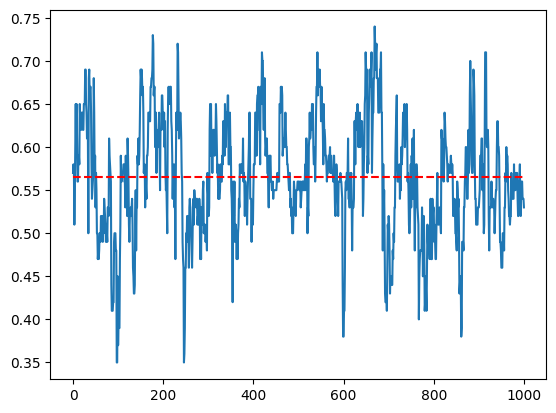

In [83]:
x = range(len(random_walk))
y = random_walk
plt.plot(x, y)
plt.plot(x, [mean(y)]*len(random_walk), "--r")

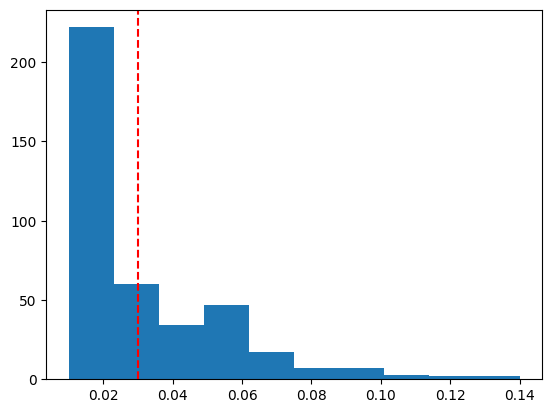

In [84]:
diff_energy = diff(random_walk)
diff_energy = diff_energy[diff_energy < 0]
diff_energy = -diff_energy
plt.hist(diff_energy)
plt.axvline(cast(float, mean(diff_energy)), color="r", linestyle="--")

In [85]:
mean(diff_energy)

0.029875311720698256

In [86]:
print(f"0.3\t{temperature_initial(random_walk, 0.3)}")
print(f"0.001\t{temperature_initial(random_walk, 0.001)}")

0.3	0.024813942319423434
0.001	0.004324894341812932
